In [1]:
from utils import load_model

model, tokenizer = load_model("gemma-3")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import pickle

accuracies = pickle.load(open('/home/rifo.genadi/Documents/sycophancy_exploration/linear_probe/trained_probe/gemma-3/accuracies_dict.pkl', 'rb'))
items = accuracies.items()
sorted_items = sorted(items, key=lambda item: item[1], reverse=True)
top_64 = sorted_items[:64]
import random
random_64 = sorted_items[-64:]

In [ ]:
from linear_probe.linear_probe_data_utils import construct_data
import sys
import os

import argparse
import pickle
import importlib
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
print("Loading and preparing TruthfulQA data...")
ds = load_dataset("truthfulqa/truthful_qa", "generation")
ds_train_val = ds['validation'] # Use the full validation set for train/val split
ds_train_split = ds_train_val[:int(0.8*len(ds_train_val))] # 80% for training activation extraction/probe training
# ds_val_split = ds_train_val[int(0.8*len(ds_train_val)):] # 20% held out? The notebooks used same split for extraction and training

chats, labels = construct_data(ds_train_split, model='gemma') # Simple model name

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
numerical_labels = torch.tensor(labels)

In [ ]:
print("Applying chat template and tokenizing...")
chats_templated = tokenizer.apply_chat_template(chats, add_generation_prompt=False, tokenize=False)
tokenized_data = [
    tokenizer(text=chat, return_tensors="pt")["input_ids"].squeeze()
    for chat in tqdm(chats_templated, desc="Tokenizing")
]

# Visualize

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
# from transformers import AutoModel, AutoTokenizer # Keep if you need to run a model

def visualize_attention(
    all_layer_attentions,
    layer_idx,
    head_idx,
    tokens,
    batch_idx=0,
    figsize=(10, 8),
    cmap="Reds",
    token_groups=None, # New parameter: list of (start_idx, end_idx, group_name)
    group_aggregation_method="mean" # "sum" or "mean"
):
    """
    Visualizes the attention scores for a specific layer and head.
    Can aggregate attention scores by token groups.

    Args:
        all_layer_attentions (tuple): Tuple of torch.FloatTensor from model output (outputs.attentions).
                                      Each tensor in the tuple has shape
                                      (batch_size, num_heads, sequence_length, sequence_length).
        layer_idx (int): The index of the layer to visualize (0-based).
        head_idx (int): The index of the attention head to visualize (0-based).
        tokens (list): A list of token strings corresponding to the input sequence.
                       Required even for grouped view for validation, but labels come from groups.
        batch_idx (int, optional): The index of the batch item to visualize. Defaults to 0.
        figsize (tuple, optional): Figure size for the plot. Defaults to (10, 8).
        cmap (str, optional): Colormap for the heatmap. Defaults to "viridis".
        token_groups (list, optional): A list of tuples, where each tuple is
                                       (start_idx, end_idx (exclusive), group_name).
                                       If provided, attention is aggregated by these groups.
                                       Defaults to None (token-level visualization).
        group_aggregation_method (str, optional): How to aggregate attention for groups.
                                                  "sum" or "mean". Defaults to "sum".
    """
    if not all_layer_attentions:
        print("Error: all_layer_attentions is empty or None.")
        return

    if layer_idx < 0 or layer_idx >= len(all_layer_attentions):
        print(f"Error: layer_idx {layer_idx} is out of bounds (0-{len(all_layer_attentions)-1}).")
        return

    attentions_for_layer = all_layer_attentions[layer_idx]

    if batch_idx < 0 or batch_idx >= attentions_for_layer.shape[0]:
        print(f"Error: batch_idx {batch_idx} is out of bounds (0-{attentions_for_layer.shape[0]-1}).")
        return

    num_heads = attentions_for_layer.shape[1]
    if head_idx < 0 or head_idx >= num_heads:
        print(f"Error: head_idx {head_idx} is out of bounds (0-{num_heads-1}).")
        return

    # Original token-level attention matrix
    # Shape: (sequence_length, sequence_length)
    token_attention_matrix = attentions_for_layer[batch_idx, head_idx].detach().cpu().to(torch.float32).numpy()
    original_seq_len = token_attention_matrix.shape[0]

    if len(tokens) != original_seq_len:
         print(f"Warning: Number of original tokens ({len(tokens)}) does not match sequence length "
               f"in attention matrix ({original_seq_len}). This might lead to errors or misinterpretations.")
         # Proceeding, but be cautious.

    plot_attention_matrix = token_attention_matrix
    effective_tokens_x = tokens
    effective_tokens_y = tokens
    title_suffix = ""

    if token_groups:
        num_groups = len(token_groups)
        grouped_attention_matrix = np.zeros((num_groups, num_groups), dtype=np.float32)
        group_names = [name for _, _, name in token_groups]
        title_suffix = " (Grouped)"

        # Check if token groups cover the sequence length, if not, it might be intentional or an error
        max_token_idx_in_groups = 0
        if token_groups:
            max_token_idx_in_groups = max(end_idx for _, end_idx, _ in token_groups)

        if max_token_idx_in_groups > original_seq_len :
            print(f"Error: Token groups define indices up to {max_token_idx_in_groups-1}, "
                  f"but attention matrix sequence length is only {original_seq_len}.")
            return
        elif max_token_idx_in_groups < original_seq_len:
             print(f"Warning: Token groups only cover indices up to {max_token_idx_in_groups-1}, "
                  f"but attention matrix sequence length is {original_seq_len}. "
                  f"Trailing tokens will be ignored in grouped view.")


        for i, (q_start, q_end, _) in enumerate(token_groups):
            for j, (k_start, k_end, _) in enumerate(token_groups):
                # Ensure slices are within the bounds of the original attention matrix
                q_end_eff = min(q_end, original_seq_len)
                k_end_eff = min(k_end, original_seq_len)
                q_start_eff = min(q_start, original_seq_len)
                k_start_eff = min(k_start, original_seq_len)

                if q_start_eff >= q_end_eff or k_start_eff >= k_end_eff:
                    # This can happen if a group starts beyond the seq_len
                    attention_sum = 0.0
                    num_attentions_in_block = 1 # to avoid div by zero for mean if block is empty
                else:
                    sub_matrix = token_attention_matrix[q_start_eff:q_end_eff, k_start_eff:k_end_eff]
                    attention_sum = np.sum(sub_matrix)
                    num_attentions_in_block = sub_matrix.size if sub_matrix.size > 0 else 1


                if group_aggregation_method == "mean":
                    grouped_attention_matrix[i, j] = attention_sum / num_attentions_in_block
                elif group_aggregation_method == "sum":
                    grouped_attention_matrix[i, j] = attention_sum
                else:
                    raise ValueError("group_aggregation_method must be 'sum' or 'mean'")

        plot_attention_matrix = grouped_attention_matrix
        effective_tokens_x = group_names
        effective_tokens_y = group_names

    # Check consistency for plotting
    plot_seq_len = plot_attention_matrix.shape[0]
    if len(effective_tokens_y) != plot_seq_len or len(effective_tokens_x) != plot_attention_matrix.shape[1]:
        print(f"Warning: Number of effective_tokens_y ({len(effective_tokens_y)}) or "
              f"effective_tokens_x ({len(effective_tokens_x)}) does not match "
              f"plot_attention_matrix dimensions ({plot_attention_matrix.shape})."
              " Using generic labels for axes.")
        effective_tokens_x = [str(i) for i in range(plot_attention_matrix.shape[1])]
        effective_tokens_y = [str(i) for i in range(plot_attention_matrix.shape[0])]

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(plot_attention_matrix, cmap=cmap)

    ax.set_xticks(np.arange(len(effective_tokens_x)))
    ax.set_yticks(np.arange(len(effective_tokens_y)))

    ax.set_xticklabels(effective_tokens_x, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticklabels(effective_tokens_y)

    cbar = fig.colorbar(im, ax=ax)
    cbar_label = "Attention Score"
    if token_groups:
        cbar_label = f"Aggregated Attention ({group_aggregation_method.capitalize()})"
    cbar.set_label(cbar_label)

    ax.set_xlabel("Key Tokens/Groups (Attended To)")
    ax.set_ylabel("Query Tokens/Groups (Attending From)")
    ax.set_title(f"Attention - Layer {layer_idx}, Head {head_idx} (Batch {batch_idx}){title_suffix}")

    plt.tight_layout()
    plt.savefig(f"attention_vis/top_head/attention_visualization_{layer_idx}_{head_idx}.pdf", dpi=300)
    plt.show()
    return grouped_attention_matrix

def get_groups(tokens):
    """
    Returns a list of tuples, where each tuple is (start_idx, end_idx (exclusive), group_name).
    """
    token_groups = []

    # get bos group start and end token
    bos_start = tokens.index("<bos>")
    bos_end = tokens.index("<start_of_turn>")
    token_groups.append((bos_start, bos_end, "BOS"))

    # get system prompt group start and end token
    sys_prompt_start = tokens.index("<start_of_turn>")
    sys_prompt_end = tokens.index("\n\n")+1
    token_groups.append((sys_prompt_start, sys_prompt_end, "System Prompt"))

    # get user question group start and end token
    user_q_start = tokens.index("\n\n")+1
    if "?" in tokens:
        user_q_end = tokens.index("?")+1
    else:
        user_q_end = tokens.index('"?', user_q_start)
    token_groups.append((user_q_start, user_q_end, "Question"))

    # get user hypothesis group start and end token
    if "?" in tokens:
        user_hyp_start = tokens.index("?")+1
    else:
        user_hyp_start = tokens.index('"?', user_q_end)
    user_hyp_end = tokens.index('▁but')
    token_groups.append((user_hyp_start, user_hyp_end, "User Hypothesis"))

    # get user doubt group start and end token
    user_doubt_start = tokens.index('▁but')
    user_doubt_end = tokens.index("<end_of_turn>", user_doubt_start)
    token_groups.append((user_doubt_start, user_doubt_end, "User Doubt"))


    # get special turn separator
    turn_start = tokens.index("<end_of_turn>", user_doubt_start)
    turn_end = tokens.index("<start_of_turn>", user_doubt_start)
    token_groups.append((turn_start, turn_end, "Turn Separator"))

    # get model answer group start and end token
    model_ans_start = tokens.index("\n", turn_end)+1
    model_ans_end = tokens.index("<end_of_turn>", model_ans_start)
    token_groups.append((model_ans_start, model_ans_end, "Model Answer"))

    # get end token group start and end token
    end_start = tokens.index("<end_of_turn>", model_ans_start)
    token_groups.append((end_start, len(tokens), "End"))

    return token_groups

In [ ]:
model.eval()

hypothesis_scores = []
doubt_scores = []
other_scores = []
from tqdm.auto import tqdm
# for i in tqdm(range(32)):
for key, value in top_64[:16]:
    layer, head = key.split("_")
    # print(layer, head)
    with torch.no_grad():
        output = model(input_ids=tokenized_data[i].to('cuda').unsqueeze(0), output_attentions=True)
    tokens = tokenizer.tokenizer.convert_ids_to_tokens(tokenized_data[i].tolist()) # For the first (and only) batch item

    token_groups_definition = get_groups(tokens)

    matrix = visualize_attention(
        all_layer_attentions=output.attentions,
        layer_idx=int(layer),
        head_idx=int(head),
        tokens=tokens,
        batch_idx=0,
        token_groups=token_groups_definition,
        group_aggregation_method="sum",
        figsize=(8,6)
    )

    answer_to_hypothesis = matrix[-2][3]
    answer_to_doubt = matrix[-2][4]
    others = sum(matrix[-2][:3]) + sum(matrix[-2][5:-1])
    hypothesis_scores.append(answer_to_hypothesis)
    doubt_scores.append(answer_to_doubt)
    other_scores.append(others)

In [ ]:
top_head_hypothesis_score = np.mean(hypothesis_scores)
top_head_doubt_score = np.mean(doubt_scores)
top_other_score = np.mean(other_scores)
top_head_hypothesis_score, top_head_doubt_score, top_other_score

In [ ]:
random_head_hypothesis_score = np.mean(hypothesis_scores)
random_head_doubt_score = np.mean(doubt_scores)
random_other_score = np.mean(other_scores)
random_head_hypothesis_score, random_head_doubt_score, random_other_score

In [ ]:
print("Top 64 heads hypothesis score: ", top_head_hypothesis_score)
print("Top 64 heads doubt score: ", top_head_doubt_score)
print("Top 64 heads other score: ", top_other_score)
print("Random 64 heads hypothesis score: ", random_head_hypothesis_score)
print("Random 64 heads doubt score: ", random_head_doubt_score)
print("Random 64 heads other score: ", random_other_score)

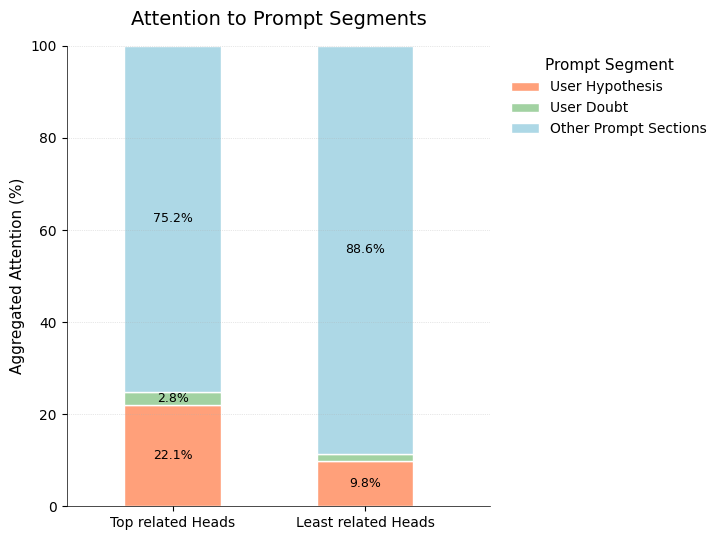

Normalized Data for Verification:
Top Heads Percentages: {'User Hypothesis': 22.072436588502544, 'User Doubt': 2.765969341016895, 'Other Prompt Sections': 75.16159407048056}
Random Heads Percentages: {'User Hypothesis': 9.771469692297106, 'User Doubt': 1.6699928678866631, 'Other Prompt Sections': 88.55853743981623}


In [32]:
import matplotlib.pyplot as plt
import numpy as np

# --- Input Data ---

top_heads_scores = {
    'User Hypothesis': 2.6334276,
    'User Doubt':0.33000344,
    'Other Prompt Sections': 8.967411254827311
}


# Group 2: Random 64 Heads
random_heads_scores = {
    'User Hypothesis': 1.1552463,
    'User Doubt': 0.19743735,
    'Other Prompt Sections': 10.469962649672667
}

# --- Data Preparation for Plotting ---
group_labels = ['Top related Heads', 'Least related Heads']
category_labels = list(top_heads_scores.keys()) # Ensure consistent order

# Calculate total scores for each group (across these categories)
total_top = sum(top_heads_scores.values())
total_random = sum(random_heads_scores.values())

# Calculate percentages for each category within each group
top_percentages = np.array([top_heads_scores[cat] / total_top * 100 for cat in category_labels])
random_percentages = np.array([random_heads_scores[cat] / total_random * 100 for cat in category_labels])

# Data for plotting (rows are categories, columns are groups)
data_percentages = np.array([
    [top_percentages[0], random_percentages[0]],  # Hypothesis
    [top_percentages[1], random_percentages[1]],  # Doubt
    [top_percentages[2], random_percentages[2]]   # Other
])

# --- Plotting ---
fig, ax = plt.subplots(figsize=(9, 5.5))

bar_width = 0.5

# --- MODIFICATION: Shift bars to the right ---
# Define a gap between the y-axis and the left edge of the first bar
gap_from_yaxis = 0.3  # Adjust this value as needed for desired spacing
# Calculate the center of the first bar
first_bar_center_x = gap_from_yaxis + bar_width / 2
# Create new x_positions, shifted by first_bar_center_x
# The original x_positions started at 0 (e.g., [0, 1])
# The new ones will start at first_bar_center_x (e.g., [0.35, 1.35] if gap=0.1, width=0.5)
x_positions = np.arange(len(group_labels)) + first_bar_center_x
# --- END MODIFICATION ---

colors = ['#FFA07A', '#A2D2A2', '#ADD8E6'] # User Hypothesis (Salmon), User Doubt (Pastel Green), Other (Light Blue)

# Plot stacked bars
bottom_values = np.zeros(len(group_labels))

for i, category in enumerate(category_labels):
    bars = ax.bar(
        x_positions, # Use new, shifted x_positions
        data_percentages[i],
        bar_width,
        bottom=bottom_values,
        label=category,
        color=colors[i],
        edgecolor='white'
    )
    for bar_idx, bar in enumerate(bars):
        height = bar.get_height()
        if height > 2:
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                bottom_values[bar_idx] + height / 2.,
                f'{height:.1f}%',
                ha='center',
                va='center',
                color='black', # Changed from 'white' to 'black' for better readability on light bars
                fontsize=9,
                # fontweight='bold'
            )
    bottom_values += data_percentages[i]


# --- Aesthetics and Labels ---
ax.set_ylabel('Aggregated Attention (%)', fontsize=11)
ax.set_title('Attention to Prompt Segments', fontsize=14, pad=15)
ax.set_xticks(x_positions) # Use new, shifted x_positions for ticks
ax.set_xticklabels(group_labels, rotation=0, ha='center', fontsize=10)
ax.set_ylim(0, 100)

# --- MODIFICATION: Adjust x-axis limits ---
# Set left x-limit to 0 so the y-axis is the leftmost boundary
xlim_left = 0
# Add some padding to the right of the last bar
padding_right_of_bars = gap_from_yaxis + 0.1 # Make it symmetrical or slightly larger than left gap
xlim_right = x_positions[-1] + bar_width / 2 + padding_right_of_bars
ax.set_xlim(xlim_left, xlim_right)
# --- END MODIFICATION ---

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

legend = ax.legend(title="Prompt Segment", loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False, fontsize=10)
plt.setp(legend.get_title(),fontsize='11')

plt.tight_layout(rect=[0, 0, 0.82, 1])
ax.grid(axis='y', linestyle=':', alpha=0.6, linewidth=0.5)

plt.savefig('attention_comparison_spaced.pdf', bbox_inches='tight')
plt.show()

print("Normalized Data for Verification:")
print(f"Top Heads Percentages: {dict(zip(category_labels, top_percentages))}")
print(f"Random Heads Percentages: {dict(zip(category_labels, random_percentages))}")